In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from preprocessing import preproc_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from kerastuner import RandomSearch
from VGG16_kt import build_model_VGG16


2024-04-25 14:10:44.947394: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 14:10:44.975173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 14:10:45.445096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
df_images = pd.read_csv('df_images.csv')
df_masks = pd.read_csv('df_masks.csv')

In [ ]:
# importation et preprocessing des images
data, target = preproc_img(df_images, df_masks, n_img=900, normalize=True, files_path='PATH_NOMASK', resolution=[224, 224, 3], with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

In [15]:
tuner = RandomSearch(
        build_model_VGG16,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=1,
        overwrite = True,
        directory='my_dir',
        project_name="VGG16final", #changer pour un nom dynamique en fonction du nom du modèle importé
        )

In [16]:
tuner.search(X_train, 
                y_train, 
                validation_data=(X_test, y_test), 
                epochs=20)

Trial 20 Complete [00h 03m 00s]
val_accuracy: 0.9466666579246521

Best val_accuracy So Far: 0.9466666579246521
Total elapsed time: 00h 59m 53s


In [17]:
best_trials = tuner.oracle.get_best_trials(num_trials=10)


results = []
   
for trial in best_trials:
    trial_data = trial.hyperparameters.values
    trial_data['score'] = trial.score
    results.append(trial_data)
   
df_results = pd.DataFrame(results)

df_results

,units,dropout,learning_rate,score
0,128,0.1,0.00001,0.946667
1,2056,0.4,0.00010,0.944444
2,256,0.4,0.00010,0.943333
3,1024,0.0,0.00010,0.943333
4,256,0.4,0.00001,0.943333
5,2056,0.2,0.00001,0.942222
6,512,0.4,0.00010,0.942222
7,128,0.0,0.00001,0.941111
8,256,0.3,0.00001,0.938889
9,256,0.2,0.00001,0.937778


In [18]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
new_model = build_model_VGG16(best_hyperparameters)

In [19]:
history = new_model.fit(X_train, 
                        y_train, 
                        epochs=30, 
                        batch_size= 64,
                        validation_data=(X_test, y_test))

Epoch 1/30


I0000 00:00:1714054184.705441  114376 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2184', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1714054184.943654  114377 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2184', 428 bytes spill stores, 428 bytes spill loads



43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.4180 - loss: 1.3218 - val_accuracy: 0.6667 - val_loss: 0.8372
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.7413 - loss: 0.7310 - val_accuracy: 0.8044 - val_loss: 0.5497
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.8077 - loss: 0.5287 - val_accuracy: 0.8178 - val_loss: 0.4831
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.8335 - loss: 0.4287 - val_accuracy: 0.8344 - val_loss: 0.3978
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.8754 - loss: 0.3412 - val_accuracy: 0.8789 - val_loss: 0.3237
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.8867 - loss: 0.3037 - val_accuracy: 0.8922 - val_loss: 0.2765
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.9128 - loss: 0.2516 - val_accuracy: 0.9111 - val_loss: 0.2497
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.9274 - loss: 0.2088 - val_accuracy: 0.9044 - val

In [20]:
# Prédiction sur l'ensemble de test
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
#print("Matrice de confusion :")
#print(conf_matrix)

# Rapport de classification
report = classification_report(y_test_classes, y_pred_classes, target_names=['COVID', 'Lung', 'Normal', 'Viral'])
print(report)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       242
        Lung       0.94      0.89      0.91       216
      Normal       0.87      0.91      0.89       216
       Viral       0.98      0.98      0.98       226

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



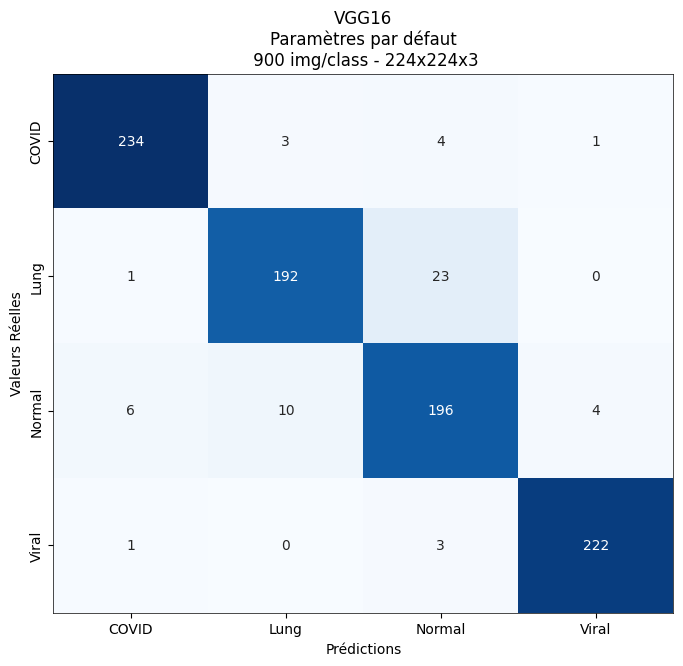

In [21]:
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['COVID', 'Lung', 'Normal', 'Viral'],
            yticklabels=['COVID', 'Lung', 'Normal', 'Viral'])
plt.title('VGG16\nParamètres par défaut\n 900 img/class - 224x224x3')
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

In [56]:
#sauvegarde du modèle
new_model.save('VGG16_finetuned.h5')

In [57]:
import pickle

In [59]:
with open('model_historyVGG16.pkl', 'wb') as file:
    pickle.dump(history.history, file)